<a id='top'></a>
<a name="top"></a><!--Need for Colab-->
# Chapter 16 – Natural Language Processing with RNNs and Attention

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/gbih/ml-notes/blob/main/book_hands_on/16_nlp_with_rnns_and_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

1. [Setup](#setup)
2. [Generating Shakespearean Text Using a Character RNN](#2.0)
    * 2.1 [Char-RNN: Splitting a sequence into batches of shuffled windows](#2.1)
    * 2.1 [Creating the Training Dataset](#2.1)
    * 2.2 [Loading the Data and Preparing the Dataset](#2.2)
    * 2.3 [How to Split a Sequential Dataset](#2.3)
    * 2.4 [Chopping the Sequential Dataset into Multiple Windows](#2.4)
    * 2.5 [Building and Training the Char-RNN Model](#2.5)
    * 2.6 [Using the Char-RNN Model](#2.6)
    * 2.7 [Generating Fake Shakespearean Text](#2.7)
    * 2.8 [Stateful RNN](#2.8)
3. [Sentiment Analysis](#3.0)
    * 3.1 [Masking](#3.1)
    * 3.2 [Reusing Pretrained Embeddings](#3.2)
4. [An Encoder-Decoder Network for Neural Machine Translation](#4.0)
    * 4.1 [Bidirectional RNNs](#4.1)
    * 4.2 [Beam Search](#4.2)
5. [Attention Mechanisms](#5.0)
    * 5.1 [Visual Attention](#5.1)
    * 5.2 [Attention is All You Need: The TransformerArchitecture](#5.2)
        - 5.2.1 [Positional Embeddings](#5.2.1)
        - 5.2.2 [Multi-Head Attention](#5.2.2)
        - 5.2.3 [Multi-Head Attention Layer](#5.2.3)
        - 5.2.4 [Keras MultiHeadAttention Layer](#5.2.4)
6. [Recent Innovations in Language Models](#6.0)


---
<a id='setup'></a>
<a name="setup"></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [1]:
try:
    import tensorflow_addons as tfa
except Exception as e:
    print(f"Error: {e}")
    print("Installing tensorflow_addons now..")
    !pip install tensorflow_addons -q
    import tensorflow_addons as tfa

Error: No module named 'tensorflow_addons'
Installing tensorflow_addons now..
     |████████████████████████████████| 1.1 MB 29.6 MB/s 


In [2]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt

# global seed
tf.random.set_seed(42)
pp = pprint.PrettyPrinter(indent=4)

print("Loaded libraries.")

def HR():
    print("-"*40)

Loaded libraries.


---
<a id='2.0'></a>
<a name="2.0"></a>
# 2. Generating Shakespearean Text Using a Character RNN
<a href="#top">[back to top]</a>

<a id='2.1'></a>
<a name="2.1"></a>
## 2.1 Char-RNN: Splitting a sequence into batches of shuffled windows
<a href="#top">[back to top]</a>

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [3]:
def listing2_1():
    np.random.seed(42)
    tf.random.set_seed(42)

    n_steps = 5
    dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
    dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(n_steps))
    dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
    dataset = dataset.batch(3).prefetch(1)

    for index, (X_batch, Y_batch) in enumerate(dataset):
        print("_" * 20, "Batch", index, "\nX_batch")
        print(X_batch.numpy())
        print("=" * 5, "\nY_batch")
        print(Y_batch.numpy())
        
listing2_1()

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


<a id='2.2'></a>
<a name="2.2"></a>
## 2.2 Loading the Data and Preparing the Dataset
<a href="#top">[back to top]</a>

In [4]:
from dataclasses import dataclass, field
import numpy as np

@dataclass(frozen=False)
class DataShakespeare:
    encoded: np.ndarray = np.array([])
    dataset_size: int = 0
    dataset: tf.Variable = tf.Variable(0)
    max_id: int = 0
    tokenizer: tf.keras.layers.TextVectorization = 0
    model: tf.Variable = tf.Variable(0)
    train_size: int = 0
    window_length: int = 0
    n_steps: int = 0

In [5]:
def listing2_2():
    
    dir_rawdata = 'chp16_assets'
    tf.io.gfile.makedirs(dir_rawdata)

    shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    filepath = keras.utils.get_file(
        "shakespeare.txt", 
        shakespeare_url,
        cache_dir=dir_rawdata
    )
    
    with open(filepath) as f:
        shakespeare_text = f.read()
        
    print(f"filepath: {filepath}")
    HR()
    print(shakespeare_text[:148])
    HR()
    
    print("".join(sorted(set(shakespeare_text.lower()))))
    HR()
    
    # Text tokenization utility class.
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
    tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
    
    # Updates internal vocabulary based on a list of texts.
    # Required before using texts_to_sequences or texts_to_matrix.
    tokenizer.fit_on_texts(shakespeare_text)
    print(f"tokenizer: {type(tokenizer)}")
    HR()

    # print("DIR OF TOKENIZER")
    # print(dir(tokenizer))
    # 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'get_config', 
    # 'index_docs', 'index_word', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 
    # sequences_to_texts', 'sequences_to_texts_generator', 'split', 'texts_to_matrix', 'texts_to_sequences', 
    # 'texts_to_sequences_generator', 'to_json', 'word_counts', 'word_docs', 'word_index']
    HR()

    # Transforms each text in texts to a sequence of integers.
    print(tokenizer.texts_to_sequences(["First"]))
    HR()
    
    # Transforms each sequence into a list of text.
    print(tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]]))
    HR()
    
    max_id = len(tokenizer.word_index) # number of distinct characters
    print(f"max_id: {max_id}")
    
    dataset_size = tokenizer.document_count # total number of characters
    print(f"dataset_size: {dataset_size}")

    [encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

    return DataShakespeare(
        encoded=encoded,
        dataset_size=dataset_size,
        max_id=max_id,
        tokenizer=tokenizer,
    )
    
data_sh = listing2_2()

print(data_sh.tokenizer)

1130496/1115394 [==============================] - 0s 0us/step
filepath: chp16_assets/datasets/shakespeare.txt
----------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

----------------------------------------

 !$&',-.3:;?abcdefghijklmnopqrstuvwxyz
----------------------------------------
tokenizer: <class 'keras_preprocessing.text.Tokenizer'>
----------------------------------------
----------------------------------------
[[20, 6, 9, 8, 3]]
----------------------------------------
['f i r s t']
----------------------------------------
max_id: 39
dataset_size: 1115394


<a id='2.3'></a>
<a name="2.3"></a>
## 2.3 How to Split a Sequential Dataset
<a href="#top">[back to top]</a>

In [6]:
def listing2_3(data):
    train_size = data.dataset_size * 90 // 100
    print(type(train_size))
    dataset = tf.data.Dataset.from_tensor_slices(data.encoded[:train_size])    
    return dataset, train_size

data_sh.dataset, data_sh.train_size = listing2_3(data_sh)

print(data_sh.dataset)
print(data_sh.train_size)

<class 'int'>
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
1003854


<a id='2.4'></a>
<a name="2.4"></a>
## 2.4 Chopping the Sequential Dataset into Multiple Windows
<a href="#top">[back to top]</a>

In [7]:
def listing2_4(data):
    
    n_steps = 100
    window_length = n_steps + 1 # target = input shifted 1 character ahead
    print(f"window_length: {window_length}")
    
    dataset = data.dataset.window(window_length, shift=1, drop_remainder=True)

    ###
    dataset = dataset.flat_map(lambda window: window.batch(window_length))

    ###
    np.random.seed(42)
    tf.random.set_seed(42)

    ###
    batch_size = 32
    dataset = dataset.shuffle(10000).batch(batch_size)
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

    ###
    dataset = dataset.map(
        lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=data.max_id), Y_batch))

    ###
    dataset = dataset.prefetch(1)
    
    ###
    
    for X_batch, Y_batch in dataset.take(1):
        print(X_batch.shape, Y_batch.shape)

    return dataset, window_length, n_steps
        
data_sh.dataset, data_sh.window_length, data_sh.n_steps = listing2_4(data_sh)

window_length: 101
(32, 100, 39) (32, 100)


<a id='2.5'></a>
<a name="2.5"></a>
## 2.5 Building and Training the Char-RNN Model
<a href="#top">[back to top]</a>

**Warning**: the following code may take up to 24 hours to run, depending on your hardware. If you use a GPU, it may take just 1 or 2 hours, or less.

**Note**: the `GRU` class will only use the GPU (if you have one) when using the default values for the following arguments: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` and `reset_after`. This is why I commented out `recurrent_dropout=0.2` (compared to the book).

In [8]:
def listing2_5(data):

    model = keras.models.Sequential([
        keras.layers.GRU(
            128, 
            return_sequences=True, 
            input_shape=[None, data.max_id],
            #dropout=0.2, recurrent_dropout=0.2),
            dropout=0.2
        ),
        keras.layers.GRU(
            128, 
            return_sequences=True,
            #dropout=0.2, recurrent_dropout=0.2),
            dropout=0.2
        ),
        keras.layers.TimeDistributed(
            keras.layers.Dense(data.max_id, activation="softmax")
        )
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="adam"
    )

    history = model.fit(
        data.dataset, 
        epochs=1 # 10
    )
    
    print(model)
    
    return model

data_sh.model = listing2_5(data_sh)

31368/31368 [==============================] - 439s 13ms/step - loss: 1.6214


In [9]:
type(data_sh.model)

keras.engine.sequential.Sequential

In [10]:
tf.io.gfile.makedirs('./chp16_model')

In [11]:
data_sh.model.save('./chp16_model/char-rnn-model')

INFO:tensorflow:Assets written to: ./chp16_model/char-rnn-model/assets


INFO:tensorflow:Assets written to: ./chp16_model/char-rnn-model/assets


In [12]:
import shutil 

shutil.make_archive(
    './chp16_model_compressed', 
    format='zip', 
    root_dir='chp16_model'
)

'/content/chp16_model_compressed.zip'

<a id='2.6'></a>
<a name="2.6"></a>
## 2.6 Using the Char-RNN Model
<a href="#top">[back to top]</a>

In [13]:
def preprocess(texts, data):
    X = np.array(data.tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, data.max_id)

In [14]:
def listing2_6(data):
    # Warning: the predict_classes() method is deprecated. 
    # Instead, we must use np.argmax(model(X_new), axis=-1).

    X_new = preprocess(["How are yo"], data)
    Y_pred = np.argmax(data.model(X_new), axis=-1)
    print(f"Y_pred: {Y_pred}")
    
    result = data.tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char
    
    print(result)
    
listing2_6(data_sh)

Y_pred: [[ 1 13  0  2  0  1  0 15  3 13]]
u


<a id='2.7'></a>
<a name="2.7"></a>
## 2.7 Generating Fake Shakespearean Text
<a href="#top">[back to top]</a>

In [15]:
def next_char(text, temperature=1):
    X_new = preprocess([text], data_sh)
    y_proba = data_sh.model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return data_sh.tokenizer.sequences_to_texts(char_id.numpy())[0]

def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [16]:
def listing2_7(data):
    
    tf.random.set_seed(42)
    tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()    
    tf.random.set_seed(42)

    next_char("How are yo", temperature=1)
    
    print(complete_text("t", temperature=0.2))
    print(complete_text("t", temperature=1))
    print(complete_text("t", temperature=2))
    
listing2_7(data_sh)

the words and words and well
and so well be to have
ty more
do iar enerobat what rast your honour, by p
tendome
than?wit? maze: yelr'vilg deain oul.-
aneuq


<a id='2.8'></a>
<a name="2.8"></a>
## 2.8 Stateful RNN
<a href="#top">[back to top]</a>

In [17]:
def listing2_8(data):

    tf.random.set_seed(42)

    dataset = tf.data.Dataset.from_tensor_slices(data.encoded[:data.train_size])
    dataset = dataset.window(data.window_length, shift=data.n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(data.window_length))
    dataset = dataset.batch(1)
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
    dataset = dataset.map(
        lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=data.max_id), Y_batch))
    dataset = dataset.prefetch(1)

    batch_size = 32
    encoded_parts = np.array_split(data.encoded[:data.train_size], batch_size)
    datasets = []
    for encoded_part in encoded_parts:
        dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
        dataset = dataset.window(data.window_length, shift=data.n_steps, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(data.window_length))
        datasets.append(dataset)
    
    dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
    dataset = dataset.map(
        lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=data.max_id), Y_batch))
    dataset = dataset.prefetch(1)

    # Note: once again, I commented out recurrent_dropout=0.2 (compared to the book) so you can get GPU acceleration (if you have one).
    model = keras.models.Sequential([
        keras.layers.GRU(128, return_sequences=True, stateful=True,
                        #dropout=0.2, recurrent_dropout=0.2,
                        dropout=0.2,
                        batch_input_shape=[batch_size, None, data.max_id]),
        keras.layers.GRU(128, return_sequences=True, stateful=True,
                        #dropout=0.2, recurrent_dropout=0.2),
                        dropout=0.2),
        keras.layers.TimeDistributed(keras.layers.Dense(data.max_id, activation="softmax"))
    ])

    class ResetStatesCallback(keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs):
            self.model.reset_states()


    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
    history = model.fit(
        dataset, 
        epochs=50,
        callbacks=[ResetStatesCallback()]
    )

    return model

stateful_rnn_model = listing2_8(data_sh)

Epoch 1/50
313/313 [==============================] - 6s 14ms/step - loss: 2.6211
Epoch 2/50
313/313 [==============================] - 4s 13ms/step - loss: 2.2422
Epoch 3/50
313/313 [==============================] - 4s 13ms/step - loss: 2.1109
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 2.0358
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 1.9854
Epoch 6/50
313/313 [==============================] - 4s 14ms/step - loss: 1.9480
Epoch 7/50
313/313 [==============================] - 5s 16ms/step - loss: 1.9206
Epoch 8/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8991
Epoch 9/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8817
Epoch 10/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8661
Epoch 11/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8533
Epoch 12/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8419
Epoch 13/50
3

In [18]:
def listing2_8b(data, stateful_rnn_model):

    # To use the model with different batch sizes, we need to create a stateless copy. 
    # We can get rid of dropout since it is only used during training:
    stateless_model = keras.models.Sequential([
        keras.layers.GRU(128, return_sequences=True, input_shape=[None, data.max_id]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(
            data.max_id,
            activation="softmax")
        )
    ])

    # To set the weights, we first need to build the model (so the weights get created):
    stateless_model.build(tf.TensorShape([None, None, data.max_id]))
    stateless_model.set_weights(stateful_rnn_model.get_weights())
    model = stateless_model

    tf.random.set_seed(42)

    print(complete_text("t"))

listing2_8b(data_sh, stateful_rnn_model)

thing id,
she muse as is these love in good on that


---
<a id='3.0'></a>
<a name="3.0"></a>
# 3. Sentiment Analysis
<a href="#top">[back to top]</a>

In [20]:
from dataclasses import dataclass, field
import numpy as np

@dataclass(frozen=False)
class DataSA:
    train_set: tf.Variable = 0
    vocab_size: int = 0 
    num_oov_buckets: int = 0 

#####

def data_sa_generate():
    tf.random.set_seed(42)

   # You can load the IMDB dataset easily:
    (X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()
    
    print(f"X_train {X_train[0][:10]}")
    HR()

    word_index = keras.datasets.imdb.get_word_index()
    id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
    for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
        id_to_word[id_] = token
    test = " ".join([id_to_word[id_] for id_ in X_train[0][:10]])

    print(f"join: {test}")
    HR()

    import tensorflow_datasets as tfds
    datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)


    print(f"dataset.keys: {datasets.keys}")
    HR()

    train_size = info.splits["train"].num_examples
    test_size = info.splits["test"].num_examples

    print(f"train_size: {train_size}, test_size: {test_size}")
    HR()

    for X_batch, y_batch in datasets["train"].batch(2).take(1):
        for review, label in zip(X_batch.numpy(), y_batch.numpy()):
            print("Review:", review.decode("utf-8")[:200], "...")
            print("Label:", label, "= Positive" if label else "= Negative")
            print()

    def preprocess(X_batch, y_batch):
        X_batch = tf.strings.substr(X_batch, 0, 300)
        X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
        X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
        X_batch = tf.strings.split(X_batch)
        return X_batch.to_tensor(default_value=b"<pad>"), y_batch

    preprocess(X_batch, y_batch)

    ###

    from collections import Counter

    vocabulary = Counter()
    for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
        for review in X_batch:
            vocabulary.update(list(review.numpy()))

    print(f"vocabulary.most_common(): {vocabulary.most_common()[:3]}")
    HR()

    print(f"len(vocabulary): {len(vocabulary)}")  
    HR()

    vocab_size = 10000
    truncated_vocabulary = [
        word for word, count in vocabulary.most_common()[:vocab_size]]

    word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
    for word in b"This movie was faaaaaantastic".split():
        print(word_to_id.get(word) or vocab_size)
    HR()

    ###

    words = tf.constant(truncated_vocabulary)
    word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
    vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
    num_oov_buckets = 1000
    table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

    ###

    print("table.lookup:")
    print(table.lookup(tf.constant([b"This movie was faaaaaantastic".split()])))
    HR()

    ###

    def encode_words(X_batch, y_batch):
        return table.lookup(X_batch), y_batch

    train_set = datasets["train"].batch(32).map(preprocess)
    train_set = train_set.map(encode_words).prefetch(1)

    ###

    for X_batch, y_batch in train_set.take(1):
        print(X_batch)
        print(y_batch)

    HR()

    return DataSA(
        train_set = train_set,
        vocab_size = vocab_size,
        num_oov_buckets = num_oov_buckets,
    )
    
data_sa = data_sa_generate()

print(data_sa)

X_train [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
----------------------------------------
join: <sos> this film was just brilliant casting location scenery story
----------------------------------------


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4QN4J7/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4QN4J7/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4QN4J7/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
dataset.keys: <built-in method keys of dict object at 0x7fdba83b5820>
----------------------------------------
train_size: 25000, test_size: 25000
----------------------------------------
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative

vocabulary.most_common(): [(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]
----------------------------------------
len(vocabulary): 53893
----------------------------------------
22
12
11
10000
-

In [21]:
def listing3_0(data):

    embed_size = 128
    
    model = keras.models.Sequential([
        keras.layers.Embedding(
            data.vocab_size + data.num_oov_buckets, 
            embed_size,
            mask_zero=True, # not shown in the book
            input_shape=[None]
        ),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(128),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss="binary_crossentropy", 
        optimizer="adam", 
        metrics=["accuracy"]
    )

    history = model.fit(
        data.train_set, 
        epochs=5
    )

listing3_0(data_sa)

Epoch 1/5
782/782 [==============================] - 22s 19ms/step - loss: 0.5305 - accuracy: 0.7281
Epoch 2/5
782/782 [==============================] - 15s 20ms/step - loss: 0.3459 - accuracy: 0.8549
Epoch 3/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1934 - accuracy: 0.9313
Epoch 4/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1361 - accuracy: 0.9503
Epoch 5/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1032 - accuracy: 0.9634


<a id='3.1'></a>
<a name="3.1"></a>
## 3.1 Masking
<a href="#top">[back to top]</a>

In [22]:
def listing3_1(data):

    print("Using manual masking:")

    K = keras.backend
    embed_size = 128

    inputs = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
    z = keras.layers.Embedding(data.vocab_size + data.num_oov_buckets, embed_size)(inputs)
    z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
    z = keras.layers.GRU(128)(z, mask=mask)
    outputs = keras.layers.Dense(1, activation="sigmoid")(z)
    
    model = keras.models.Model(
        inputs=[inputs], 
        outputs=[outputs]
    )
    
    model.compile(
        loss="binary_crossentropy", 
        optimizer="adam", 
        metrics=["accuracy"]
    )
    
    history = model.fit(
        data.train_set, 
        epochs=5
    )

listing3_1(data_sa)

Using manual masking:
Epoch 1/5
782/782 [==============================] - 22s 19ms/step - loss: 0.5426 - accuracy: 0.7156
Epoch 2/5
782/782 [==============================] - 15s 20ms/step - loss: 0.3469 - accuracy: 0.8571
Epoch 3/5
782/782 [==============================] - 15s 19ms/step - loss: 0.1757 - accuracy: 0.9390
Epoch 4/5
782/782 [==============================] - 15s 19ms/step - loss: 0.1314 - accuracy: 0.9521
Epoch 5/5
782/782 [==============================] - 15s 19ms/step - loss: 0.1108 - accuracy: 0.9585


<a id='3.2'></a>
<a name="3.2"></a>
## 3.2 Reusing Pretrained Embeddings
<a href="#top">[back to top]</a>

In [23]:
def listing3_2():

    tf.random.set_seed(42)

    TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
    os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

    import tensorflow_hub as hub

    model = keras.Sequential([
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
            dtype=tf.string, 
            input_shape=[], 
            output_shape=[50]
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy", 
        optimizer="adam",
        metrics=["accuracy"]
    )

    ###

    for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
        for filename in filenames:
            print(os.path.join(dirpath, filename))

    HR()

    ###

    import tensorflow_datasets as tfds

    datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
    train_size = info.splits["train"].num_examples
    batch_size = 32
    train_set = datasets["train"].batch(batch_size).prefetch(1)

    # Using the pretrained model we downloaded above
    history = model.fit(train_set, epochs=5)

listing3_2()

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
----------------------------------------
Epoch 1/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5461 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5130 - accuracy: 0.7495
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5081 - accuracy: 0.7532
Epoch 4/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5047 - accuracy: 0.7540
Epoch 5/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5018 - accuracy: 0.7566


---
<a id='4.0'></a>
<a name="4.0"></a>
# 4. An Encoder-Decoder Network for Neural Machine Translation

<a href="#top">[back to top]</a>

In [24]:
def listing4_0():
    tf.random.set_seed(42)
    vocab_size = 100
    embed_size = 10

    ###

    import tensorflow_addons as tfa

    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

    embeddings = keras.layers.Embedding(vocab_size, embed_size)
    encoder_embeddings = embeddings(encoder_inputs)
    decoder_embeddings = embeddings(decoder_inputs)

    encoder = keras.layers.LSTM(512, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
    encoder_state = [state_h, state_c]

    sampler = tfa.seq2seq.sampler.TrainingSampler()

    decoder_cell = keras.layers.LSTMCell(512)
    output_layer = keras.layers.Dense(vocab_size)
    decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                    output_layer=output_layer)
    final_outputs, final_state, final_sequence_lengths = decoder(
        decoder_embeddings, initial_state=encoder_state,
        sequence_length=sequence_lengths)
    Y_proba = tf.nn.softmax(final_outputs.rnn_output)

    model = keras.models.Model(
        inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
        outputs=[Y_proba])

    ###

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

    ###

    X = np.random.randint(100, size=10*1000).reshape(1000, 10)
    Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
    X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
    seq_lengths = np.full([1000], 15)

    history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

    print(model.summary())

listing4_0()

Epoch 1/2
32/32 [==============================] - 4s 42ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 1s 43ms/step - loss: 4.6037
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 10)     1000        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                 

<a id='4.1'></a>
<a name="4.1"></a>
## 4.1 Bidirectional RNNs
<a href="#top">[back to top]</a>

In [25]:
def listing4_1():
    tf.random.set_seed(42)
    vocab_size = 100
    embed_size = 10

    ###

    import tensorflow_addons as tfa

    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

    embeddings = keras.layers.Embedding(vocab_size, embed_size)
    encoder_embeddings = embeddings(encoder_inputs)
    decoder_embeddings = embeddings(decoder_inputs)

    encoder = keras.layers.LSTM(512, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
    encoder_state = [state_h, state_c]

    sampler = tfa.seq2seq.sampler.TrainingSampler()

    decoder_cell = keras.layers.LSTMCell(512)
    output_layer = keras.layers.Dense(vocab_size)
    decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                    output_layer=output_layer)
    final_outputs, final_state, final_sequence_lengths = decoder(
        decoder_embeddings, initial_state=encoder_state,
        sequence_length=sequence_lengths)
    Y_proba = tf.nn.softmax(final_outputs.rnn_output)

    # model = keras.models.Model(
    #     inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    #     outputs=[Y_proba])


    model = keras.models.Sequential([
        keras.layers.GRU(
            10, 
            return_sequences=True, 
            input_shape=[None, 10]
            ),

        keras.layers.Bidirectional(
            keras.layers.GRU(10, return_sequences=True)    
        )
    ])

    ###

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

    ###

    X = np.random.randint(100, size=10*1000).reshape(1000, 10)
    Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
    X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
    seq_lengths = np.full([1000], 15)

    #history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

    print(model.summary())

listing4_1()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, None, 10)          660       
                                                                 
 bidirectional (Bidirectiona  (None, None, 20)         1320      
 l)                                                              
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________
None


<a id='4.2'></a>
<a name="4.2"></a>
## 4.2 Beam Search
<a href="#top">[back to top]</a>

No source code

<a id='5.0'></a>
<a name="5.0"></a>
# 5.0 Attention Mechanisms
<a href="#top">[back to top]</a>

No source code

<a id='5.1'></a>
<a name="5.1"></a>
## 5.1 Visual Attention
<a href="#top">[back to top]</a>

No source code

<a id='5.2'></a>
<a name="5.2"></a>
## 5.2 Attention is All You Need: The Transformer Architecture
<a href="#top">[back to top]</a>

No source code

<a id='5.2.1'></a>
<a name="5.2.1"></a>
### 5.2.1 Positional Encoding
<a href="#top">[back to top]</a>

Currently there is no `PositionalEmbedding` layer in TensorFlow, so we implement one here.

In [26]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

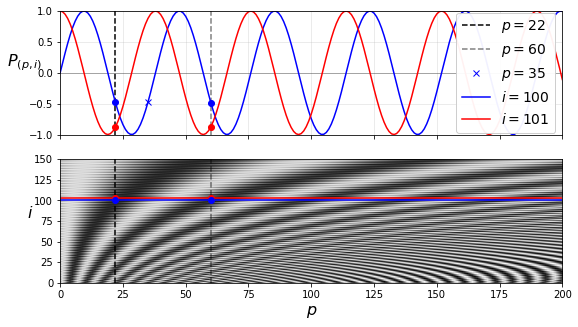

In [27]:
def listing5_2_1():

    max_steps = 201
    max_dims = 512
    pos_emb = PositionalEncoding(max_steps, max_dims)
    PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

    ###

    i1, i2, crop_i = 100, 101, 150
    p1, p2, p3 = 22, 60, 35
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
    ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
    ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
    ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
    ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
    ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
    ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
    ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
    ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
    ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
    ax1.axis([0, max_steps - 1, -1, 1])
    ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
    ax2.hlines(i1, 0, max_steps - 1, color="b")
    cheat = 2 # need to raise the red line a bit, or else it hides the blue one
    ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
    ax2.plot([p1, p1], [0, crop_i], "k--")
    ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
    ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
    ax2.plot([p1, p2], [i1, i1], "bo")
    ax2.axis([0, max_steps - 1, 0, crop_i])
    ax2.set_xlabel("$p$", fontsize=16)
    ax2.set_ylabel("$i$", rotation=0, fontsize=16)
    plt.show()

    ###

    # Create the first layers of the Transformer:
    embed_size = 512; max_steps = 500; vocab_size = 10000
    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    embeddings = keras.layers.Embedding(vocab_size, embed_size)
    encoder_embeddings = embeddings(encoder_inputs)
    decoder_embeddings = embeddings(decoder_inputs)
    positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
    encoder_in = positional_encoding(encoder_embeddings)
    decoder_in = positional_encoding(decoder_embeddings)

listing5_2_1()

<a id='5.2.2'></a>
<a name="5.2.2"></a>
### 5.2.2 Multi-Head Attention
<a href="#top">[back to top]</a>

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention).

We use `keras.layers.Attention` layer as it implements Scaled Dot-Product Attention.

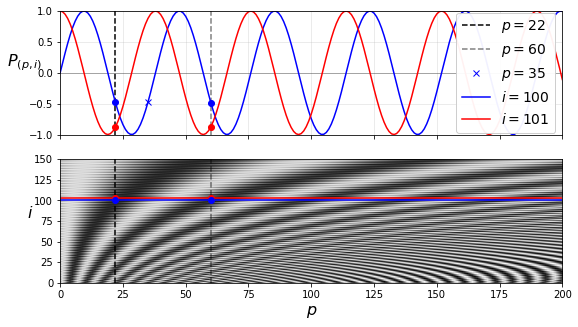

In [28]:
def listing5_2_2():

    max_steps = 201
    max_dims = 512
    pos_emb = PositionalEncoding(max_steps, max_dims)
    PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

    ###

    i1, i2, crop_i = 100, 101, 150
    p1, p2, p3 = 22, 60, 35
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
    ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
    ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
    ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
    ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
    ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
    ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
    ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
    ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
    ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
    ax1.axis([0, max_steps - 1, -1, 1])
    ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
    ax2.hlines(i1, 0, max_steps - 1, color="b")
    cheat = 2 # need to raise the red line a bit, or else it hides the blue one
    ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
    ax2.plot([p1, p1], [0, crop_i], "k--")
    ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
    ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
    ax2.plot([p1, p2], [i1, i1], "bo")
    ax2.axis([0, max_steps - 1, 0, crop_i])
    ax2.set_xlabel("$p$", fontsize=16)
    ax2.set_ylabel("$i$", rotation=0, fontsize=16)
    plt.show()

    ###

    embed_size = 512; max_steps = 500; vocab_size = 10000
    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
    embeddings = keras.layers.Embedding(vocab_size, embed_size)
    encoder_embeddings = embeddings(encoder_inputs)
    decoder_embeddings = embeddings(decoder_inputs)
    positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
    encoder_in = positional_encoding(encoder_embeddings)
    decoder_in = positional_encoding(decoder_embeddings)

    ###

    Z = encoder_in
    for N in range(6):
        Z = keras.layers.Attention(use_scale=True)([Z, Z])

    encoder_outputs = Z
    Z = decoder_in
    for N in range(6):
        Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
        Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

    outputs = keras.layers.TimeDistributed(
        keras.layers.Dense(vocab_size, activation="softmax"))(Z)

listing5_2_2()

<a id='5.2.3'></a>
<a name="5.2.3"></a>
### 5.2.3 Multi-Head Attention Layer
<a href="#top">[back to top]</a>

Here's a basic implementation of the `MultiHeadAttention` layer. 

One will likely be added to `keras.layers` in the near future. 

Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [29]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)
        

In [30]:
def listing5_2_3():

    Q = np.random.rand(2, 50, 512)
    V = np.random.rand(2, 80, 512)
    multi_attn = MultiHeadAttention(8)
    
    print(multi_attn([Q, V]).shape)

listing5_2_3()

(2, 50, 512)


<a id='5.2.4'></a>
<a name="5.2.4"></a>
### 5.2.4 Keras MultiHeadAttention Layer
<a href="#top">[back to top]</a>

* tf.keras.layers.MultiHeadAttention

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

This is an implementation of multi-headed attention as described in the paper "Attention is all you Need" (Vaswani et al., 2017). If query, key, value are the same, then this is self-attention. Each timestep in query attends to the corresponding sequence in key, and returns a fixed-width vector.

This layer first projects query, key and value. These are (effectively) a list of tensors of length num_attention_heads, where the corresponding shapes are (batch_size, <query dimensions>, key_dim), (batch_size, <key/value dimensions>, key_dim), (batch_size, <key/value dimensions>, value_dim).

Then, the query and key tensors are dot-producted and scaled. These are softmaxed to obtain attention probabilities. The value tensors are then interpolated by these probabilities, then concatenated back to a single tensor.

Finally, the result tensor with the last dimension as value_dim can take an linear projection and return.

When using MultiHeadAttention inside a custom Layer, the custom Layer must implement build() and call MultiHeadAttention's _build_from_signature(). This enables weights to be restored correctly when the model is loaded.

when used in a custom Layer.
Examples:
Performs 1D cross-attention over two sequence inputs with an attention mask. Returns the additional attention weights over heads.

In [31]:
def listing5_2_4():
    # Performs 1D cross-attention over two sequence inputs with an 
    # attention mask. Returns the additional attention weights over heads.
    layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2)
    target = tf.keras.Input(shape=[8, 16])
    source = tf.keras.Input(shape=[4, 16])
    output_tensor, weights = layer(
        target, 
        source,
        return_attention_scores=True
    )

    print(f"output_tensor.shape: {output_tensor.shape}")
    print(f"weights.shape: {weights.shape}")

listing5_2_4()

output_tensor.shape: (None, 8, 16)
weights.shape: (None, 2, 8, 4)


In [32]:
def listing5_2_4b():
    
    # Performs 2D self-attention over a 5D input tensor on axes 2 and 3.
    layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3))
    input_tensor = tf.keras.Input(shape=[5, 3, 4, 16])
    output_tensor = layer(input_tensor, input_tensor)
    print(f"output_tensor.shape: {output_tensor.shape}")

listing5_2_4b()

output_tensor.shape: (None, 5, 3, 4, 16)


In [33]:
def listing5_2_4c():

    # https://github.com/keras-team/keras/issues/16248#issue-1170657214

    # Transformer:
    # encoder_input_ids = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
    # encoder_embeddings = tf.keras.layers.Embedding(1000, 512)(encoder_input_ids)
    # attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=512)
    # encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)  # shape [B, S]
    # attention_mask = encoder_pad_mask[:, tf.newaxis]  # shape [B, 1, S]
    # outputs = attn_layer(encoder_embeddings, value=encoder_embeddings,
    #                     attention_mask=attention_mask)

    encoder_input_ids = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
    encoder_embeddings = tf.keras.layers.Embedding(1000, 512, mask_zero=True)(encoder_input_ids)
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=512)
    outputs = attn_layer(encoder_embeddings, value=encoder_embeddings)

listing5_2_4c()

<a id='6.0'></a>
<a name="6.0"></a>
# 6.0 Recent Innovations in Language Models
<a href="#top">[back to top]</a>

No source code